# AIIR Project - AI Mario
This jupyter notebook contains the application of nueral network and reinforcement learning algorithms learnt from the tutorials to simulate Mario completing a variety of levels in a pybullet gym environment.


## Mario Environment
We use a Super Mario Bros environment (https://pypi.org/project/gym-super-mario-bros/) with a continuous state space and discrete action space. The goal of this activity is to complete Mario levels as fast as possible. Episodes end when Mario reaches the end of the level, if Mario dies, or if a certain time as elapsed.

### Action Space
- 0: No Movement
- 1: Move Right
- 2: Move Right + Jump
- 3: Move Right + Speed Up
- 4: Move Right + Jump + Speed Up
- 5: Jump
- 6: Move Left
- 7: Move Left + Jump
- 8: Move Left + Speed Up
- 9: Move Left + Jump + Speed Up
- 10: Down
- 11: Up

### Observation Space
The info dictionary returned by step contains the following:
| Key | Unit | Description |
| --- | ---- | ----------- |
| coins | int | Number of collected coins |
| flag_get | bool | True if Mario reached a flag |
| life | int | Number of lives left |
| score | int | Cumulative in-game score |
| stage | int | Current stage |
| status | str | Mario's status/power |
| time | int | Time left on the clock |
| world | int | Current world |
| x_pos | int | Mario's x position in the stage |
| y_pos | int | Mario's y position in the stage |

### Rewards
| Feature | Description | Value when Positive | Value when Negative | Value when Equal |
|---------|-------------|---------------------|---------------------|------------------|
| Difference in agent x values between states | Controls agent's movement | Moving right | Moving left | Not moving |
| Time difference in the game clock between frames | Prevents agent from staying still | - | Clock ticks | Clock doesn't tick |
| Death Penalty | Discourages agent from death | - | Agent dead | Agent alive |
| Coins | Encourages agent to get coins | Coin collected | - | No coin collected |
| Score | Encourages agent to get higher score | Score Value | Score Value | Score Value |
| Flag | Encourages agent to reach middle & end flag | Flag collected | - | Flag not collected |
| Powerup | Encourages agent to get powerups | Powerup collected | - | Powerup not collected |

## Installation Guide
For installing the Super Mario Bros gym environment package, use the following command using a python 3.8 kernel:

In [ ]:
%pip install gym-super-mario-bros

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


Importing the necessary packages and following helper function to display video runs within jupyter notebook

In [2]:
import os
os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0' 

import gym
import pybullet as p
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import random
import math
from collections import deque

display = Display(visible=0, size=(400, 300))
display.start()

def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

pybullet build time: Nov 28 2023 23:51:11


## Hyperparameters

In [11]:
# Hyperparameters
EPISODES = 2500                  # Number of episodes to run for training
LEARNING_RATE = 0.00025          # Learning rate for optimizing neural network weights
MEM_SIZE = 50000                 # Maximum size of replay memory
REPLAY_START_SIZE = 10000        # Amount of samples to fill replay memory before training
BATCH_SIZE = 32                  # Number of samples to draw from replay memory for training
GAMMA = 0.99                     # Discount factor for future rewards
EPSILON_START = 0.1              # Starting exploration rate
EPSILON_END = 0.0001             # Final exploration rate
EPSILON_DECAY = 4 * MEM_SIZE     # Decay rate for exploration rate
MEM_RETAIN = 0.1                 # Percentage of memory to retain on each episode
NETWORK_UPDATE_ITERS = 5000      # Number of steps to update target network 
MAX_STEPS = 5                    # Maximum number of steps per episode              

FC1_DIMS = 512                   # Number of neurons in first fully connected layer
FC2_DIMS = 512                   # Number of neurons in second fully connected layer

# Metrics for displaying training status
best_reward = 0
average_reward = 0
episode_history = []
episode_reward_history = []
np.bool = np.bool_

## Neural Network
Below is the class definition for a neural network used to approximate Q-values for the use within a reinforcement learning framework.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Neural network class to approximate Q-values
class NeuralNetwork(torch.nn.Module):
    def __init__(self, env, freeze=False):
        super().__init__()  # Inheriting from torch.nn.Module

        self.input_shape = env.observation_space.shape  # Getting shape of observation space
        self.action_space = env.action_space.n          # Getting number of actions in action space

        # Defining convolutional layers
        # Convolutional Neural Network (CNN) used for image inputs
        self.conv_layers = torch.nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.ReLU(),
        )

        # Getting the output size of the convolutional layers
        conv_out_size = self._get_conv_out(self.input_shape)

        # Defining the linear layers
        self.layers = torch.nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, FC1_DIMS),
            nn.ReLU(),
            nn.Linear(FC1_DIMS, FC2_DIMS),
            nn.ReLU(),
            nn.Linear(FC2_DIMS, self.action_space)
        )

        if freeze:
            self._freeze()

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)  # Optimizer
        self.loss = nn.MSELoss()  # Loss Function

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device to run the network on
        self.to(self.device)  # Moving the network to the device

    def forward(self, x):
        return self.layers(x)  # Forward pass through the network
    
    def _get_conv_out(self, shape):
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    # Function to freeze NN learning
    def _freeze(self):
        for param in self.parameters():
            param.requires_grad = False

## Reinforcement Learning

In [5]:
# Replay Buffer class for storing and retrieving sampled experiences
class ReplayBuffer:
    def __init__(self, env, mem_size=MEM_SIZE):
        # Initialising memory count and creating arrays to store experiences
        self.memory = deque(maxlen=mem_size)
        self.mem_count = 0

    def add(self, state, action, reward, state_, done):
        # Adding experience to memory
        self.memory.append((state, action, reward, state_, done))
        self.mem_count += 1

    def sample(self):
        # Randomly sample a batch of experiences
        batch_size = min(BATCH_SIZE, self.mem_count)
        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, states_, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_), np.array(dones)
    
    def __len__(self):
        return self.mem_count

In [6]:
class Agent:
    def __init__(self, env):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define the device to run the network on
        self.memory = ReplayBuffer(env, MEM_SIZE)     # Creating a replay buffer
        self.policy_network = NeuralNetwork(env)  # Q
        self.target_network = NeuralNetwork(env)  # \hat{Q}
        self.target_network.load_state_dict(self.policy_network.state_dict())  # Initially set weights of Q to \hat{Q}
        self.learn_count = 0    # keep track of the number of iterations we have learnt for

    # Epsilon-greedy policy
    def choose_action(self, observation):
        # Only start decaying epsilon once we start learning (once replay memory has REPLAY_START_SIZE samples)
        if self.memory.mem_count > REPLAY_START_SIZE:
            eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * \
                math.exp(-1. * self.learn_count / EPSILON_DECAY)
        else:
            eps_threshold = 1.0

        # If we rolled a value lower than the epsilon sample a random action
        if random.random() < eps_threshold:
            return np.random.choice(np.array(range(12)), p=[0.05, 0.1, 0.1, 0.1, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05])  # Random action with set priors
        
        # Otherwise policy network (Q) chooses action with highest estimated Q value so far
        state = torch.tensor(observation.copy()).float().detach().to(self.device)
        state = state.unsqueeze(0)
        self.policy_network.eval()
        with torch.no_grad():
            q_values = self.policy_network(state)  # Get Q-values from policy network

        return torch.argmax(q_values).item()
    
    # Main training loop
    def learn(self):
        if len(self.memory) < REPLAY_START_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()  # Sample a batch of random experiences
        states = torch.tensor(states, dtype=torch.float32).to(self.device)      # Convert states to tensor
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)       # Convert actions to tensor
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)    # Convert rewards to tensor
        states_ = torch.tensor(states_, dtype=torch.float32).to(self.device)    # Convert next states to tensor
        dones = torch.tensor(dones, dtype=torch.bool).to(self.device)           # Convert done flags to tensor
        batch_indices = torch.from_numpy(np.arange(BATCH_SIZE, dtype=np.int64)).to(self.device)   # Create an array of batch indices

        self.policy_network.train(True)
        q_values = self.policy_network(states)  # Get Q-value estimates from policy network
        q_values = q_values[batch_indices, actions]  # Get Q-values for the sampled actions

        self.target_network.eval()
        with torch.no_grad():
            q_values_next = self.target_network(states_)  # Get Q-values of states_ from target nework (Q_hat)

        q_values_next_max = torch.max(q_values_next, dim=1)[0]  # Max Q-values for next state
        q_target = rewards + GAMMA * q_values_next_max * dones  # Calculate target Q-values

        loss = self.policy_network.loss(q_values, q_target)  # Calculate loss from target Q-values and predicted Q-values

        # Compute gradients and update Q weights
        self.policy_network.optimizer.zero_grad()
        loss.backward()
        self.policy_network.optimizer.step()  # Update Q weights
        self.learn_count += 1  # Increment learn count

        # Set target network weights to policy networks wights every C steps
        if self.learn_count % NETWORK_UPDATE_ITERS == NETWORK_UPDATE_ITERS - 1:
            print("Updating target network")
            self.update_target_network()
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def returning_epsilon(self):
        return self.exploration_rate

## Training the AI
The following code uses the above Neural Network and Reinforcement Learning framework to train the AI to play Super Mario Bros on a variety of its levels.

In [7]:
# Function to apply additional rewards that aren't in the environment already
def reward_shaping(prev_info, info):
    shapedReward = 0  # Container to store the additional reward
    reward_values = {  # Container to store keys for rewards
        'coins': 1,
        'score': lambda previous, current: current - previous,
        'flag_get': 50,
        'powerup': lambda previous, current: 10 if current > previous else 0
    }

    # Applying the reward values to the shaped reward
    for key, reward in reward_values.items():
        prev_value = prev_info.get(key, 0)  # Getting the previous info values for keys
        curr_value = info.get(key, 0)       # Getting the current info values for keys

        # If the reward is a function, apply the function to the previous and current values
        if callable(reward):
            shapedReward += reward(prev_value, curr_value)

        # Otherwise, apply the reward value to the shaped reward
        elif curr_value > prev_value:
            shapedReward += reward

    return shapedReward  # Return the shaped reward

Using CUDA device: NVIDIA RTX A2000 Laptop GPU
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to fill...
waiting for buffer to f

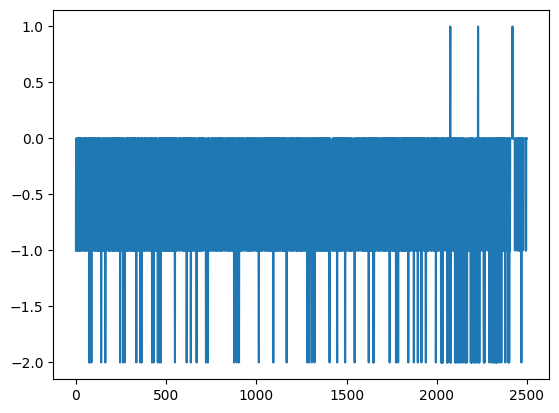

In [12]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
import gym

if torch.cuda.is_available():
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

# Loading the Super Mario Bros envrionment and setting movement mode
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = JoypadSpace(env, COMPLEX_MOVEMENT)

episode_batch_score = 0     # Initialize episode score
episode_reward = 0          # Initialize episode reward
prev_info = None            # Initialize previous info container
agent = Agent(env)          # Create RL agent
plt.clf()                   # Clear previous plot

# Load the saved model if it exists already (for further training)
save_path = os.path.join(os.getcwd(), "policy_network.pkl")
if os.path.exists(save_path):
    agent.policy_network.load_state_dict(torch.load(save_path))

env.reset()  # Reseting environment
state_, reward, done, trunc, info = env.step(action=0)  # Taking a step in the environment

for i in range(EPISODES):
    done = False
    state, info = env.reset()
    step_count = 0

    while not done and step_count < MAX_STEPS:
        action = agent.choose_action(state)                     # Choosing action
        state_, reward, done, _, info = env.step(action)        # Taking a step in the environment

        ## Adding additional reward systems ##
        if prev_info is not None:
            reward += reward_shaping(prev_info, info)

        agent.memory.add(state, action, reward, state_, done)   # Adding experience to replay buffer
        # Learning from experiences in replay buffer once start size is reached
        if agent.memory.mem_count >= REPLAY_START_SIZE:
            agent.learn()

        state = state_                  # Updating state
        prev_info = info                # Updating previous info
        episode_batch_score += reward   # Updating episode score
        episode_reward += reward        # Updating episode reward
        step_count += 1                 # Incrementing step count

    episode_history.append(i)                       # Appending episode number to history
    episode_reward_history.append(episode_reward)   # Appending episode reward to history
    episode_reward = 0                              # Resetting episode reward

    # Saving the model every 100 episodes
    if i % 100 == 0 and len(agent.memory) > REPLAY_START_SIZE:
        save_path = os.path.join(os.getcwd(), "policy_network.pkl")
        torch.save(agent.policy_network.state_dict(), save_path)
        print("average total reward per episode batch since episode ", i, ": ", episode_batch_score/ float(100))
        episode_batch_score = 0
    elif agent.memory.mem_count < REPLAY_START_SIZE:
        print("waiting for buffer to fill...")
        episode_batch_score = 0

plt.plot(episode_history, episode_reward_history)
plt.show()
env.close()

## Testing the AI
The following code tests the AI policy generated during training in random Super Mario Bros levels.

In [14]:
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = JoypadSpace(env, COMPLEX_MOVEMENT)

agent = Agent(env)
agent.policy_network.load_state_dict(torch.load("policy_network.pkl"))
state = env.reset()
frames = []
frames.append(env.render())
agent.policy_network.eval()

while True:
    with torch.no_grad():
        q_values = agent.policy_network(torch.tensor(state, dtype=torch.float32))

    action = torch.argmax(q_values).item()
    state, reward, done, truncated, info = env.step(action)
    frames.append(np.copy(env.render()))

    if done:
        break

env.close()
display_video(frames)                                  

/tmp/ipykernel_23858/2949811299.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  q_values = agent.policy_network(torch.tensor(state, dtype=torch.float32))


ValueError: expected sequence of length 240 at dim 1 (got 0)